Origin-destination matrix estimation: Gravity model

In [27]:
import skmob
from skmob.utils import utils, constants
import pandas as pd
import geopandas as gpd
import numpy as np
from skmob.models import gravity
from skmob.models.gravity import Gravity

import map_functions
#import computing_functions
import matplotlib.pyplot as plt
import networkx as nx


#### 16 cities

In [40]:
from shapely.geometry import Point

ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows = pd.read_csv("data/sources/KSH/KSHCommuting_c1ID_c1name_c2ID_c2name_comm_school_work_UNDIR.csv")
ksh_flows_dir = pd.read_csv("data/sources/KSH/KSHCommuting_c1ID_c1name_c2ID_c2name_comm_school_work_DIR.csv")
gdf_hungary = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")
#crs = gdf_hungary.crs
crs = "EPSG:4326"
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']
countries = ['Ausztria', 'Szlovákia', 'Ukrajna', 'Románia', 'Szerbia', 'Horvátország', 'Szlovénia']

In [41]:
place_id_dict = {}
for key, value in zip(ksh_flows_dir['origName'], ksh_flows_dir['origID']):
    if key in place_id_dict.keys():
        if place_id_dict[key] != value:
            print(key), print(value), print(place_id_dict[key])
    else:
        place_id_dict[key] = value
place_id_dict['Budapest'] = 13578

for i, row in ksh_flows.iterrows():
    if row['origName'] in place_id_dict.keys():
        ksh_flows.at[i, 'origID'] = place_id_dict[row['origName']]
    elif "Budapest" == (row['origName']):
        ksh_stats.at[i, 'origID'] = 13578
    elif row['origName'] not in countries:
        print(f"Problem with origName: {row['origName']}")
        print(row)

    if row['destName'] in place_id_dict.keys():
        ksh_flows.at[i, 'destID'] = place_id_dict[row['destName']]
    elif "Budapest" in (row['destName']):
        ksh_flows.at[i, 'destID'] = 13578
    elif row['destName'] not in countries:
        print(f"Problem with destName: {row['destName']}")
        print(row)

id_place_dict = { v:k for k, v in place_id_dict.items()}

Mátyus
20677
20668
Tibolddaróc
30456
30447


In [42]:
def replace_letters(s):
    return s.replace("õ", "ő").replace("Õ", "Ő").replace("û", "ű").replace("Û", "Ű")
#non_english_letters = r'[^a-zA-Z]'; non_hungarian_letters = r'[^a-zA-ZáéíóöőúüűÁÉÍÓÖŐÚÜŰ]'
#non_hungarian = ksh_stats['Settlement_Name'].str.contains(non_hungarian_str, regex=True)
ksh_stats['Settlement_Name'] = ksh_stats['Settlement_Name'].apply(replace_letters)
ksh_flows['origName'] = ksh_flows['origName'].apply(replace_letters)
ksh_flows['destName'] = ksh_flows['destName'].apply(replace_letters)

ksh_flows.to_csv("data/sources/KSH/Commuting_undirected_corrected.csv", index=False)

In [43]:
ksh_flows['origName'] = ksh_flows['origName'].apply(lambda x: 'Budapest' if 'Budapest' in x else x)
ksh_flows['destName'] = ksh_flows['destName'].apply(lambda x: 'Budapest' if 'Budapest' in x else x)

ksh_flows.loc[ksh_flows['origName'] == 'Budapest', 'origID'] = 13578
ksh_flows.loc[ksh_flows['destName'] == 'Budapest', 'destID'] = 13578

#Combine cases where the origName and destName are switched
ksh_flows['orig_dest'] = list(zip(ksh_flows['origID'], ksh_flows['destID']))
ksh_flows['orig_dest'] = ksh_flows['orig_dest'].apply(lambda x: tuple(sorted(x)))
ksh_flows_temp = ksh_flows.groupby(['orig_dest'])['CommutersAll', 'CommutersSchool', 'CommutersWork'].sum().reset_index()
ksh_flows_temp[['origID', 'destID']] = pd.DataFrame(ksh_flows_temp['orig_dest'].tolist(), index=ksh_flows_temp.index)
ksh_flows_temp = ksh_flows_temp.drop(columns=['orig_dest'])
ksh_flows = ksh_flows_temp.copy()
ksh_flows['origName'] = ksh_flows['origID'].apply(lambda x: id_place_dict[x])
ksh_flows['destName'] = ksh_flows['destID'].apply(lambda x: id_place_dict[x])
#Sum the last three columns for each pair of origID and destID
ksh_flows_combined = ksh_flows.groupby(['origID', 'origName', 'destID', 'destName'])['CommutersAll', 'CommutersSchool', 'CommutersWork'].sum().reset_index()

geometry = [Point(xy) for xy in zip(ksh_stats['longitude'], ksh_stats['latitude'])]
gdf_ksh = (gpd.GeoDataFrame(ksh_stats, crs="EPSG:4326", geometry=geometry)).to_crs(crs)

gdf_16 = gdf_ksh[gdf_ksh['Settlement_Name'].isin(cities)]
odf_16 = ksh_flows_combined[(ksh_flows_combined['origName'].isin(cities)) & (ksh_flows_combined['destName'].isin(cities))]
odf_16 = odf_16.rename(columns={'origID': 'origin', 'destID': 'destination', 'CommutersAll': 'flow'})
odf_16 = odf_16.drop(columns=['CommutersSchool', 'CommutersWork', 'origName', 'destName'])
odf_16 = odf_16[[odf_16.columns[-1]]+list(odf_16.columns[:-1])] #Swap the columns
odf_16 = pd.concat([odf_16, pd.DataFrame([{'flow':0,'origin': place_id_dict['Szekszárd'], 'destination':place_id_dict['Nyíregyháza']}])], ignore_index=True)


gdf_bp = gdf_ksh[gdf_ksh['Settlement_Name'].str.contains("Budapest")]
gdf_bp['Settlement_Name'] = 'Budapest'
bp_aggregations = {col: 'first' for col in gdf_bp.columns} #Select the first value of each column
bp_aggregations['Population'] = 'sum' #except for 'Population', which is summed
#Groupby,aggregate
gdf_bp = gdf_bp.groupby('Settlement_Name', as_index=False).agg(bp_aggregations)

gdf_16 = pd.concat([gdf_bp,gdf_16 ], ignore_index=True)

tessellation_16 = gdf_16.copy().drop(columns=[ 'latitude', 'longitude','Settlement_Name']).rename(columns={'Settlement_ID': 'tile_ID', 'Population': 'population'})
tessellation_16 = gpd.GeoDataFrame(tessellation_16, geometry='geometry')
tessellation_16.crs = crs
tessellation_16['tile_ID'][0] = 13578

tessellation_16.to_file("data/sources/KSH/tessellation_16_cities.geojson", driver='GeoJSON')
odf_16.to_csv("data/sources/KSH/flows_16_cities.csv", index=False)

C:\Users\hanic\AppData\Local\Temp\ipykernel_39164\1262939418.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ksh_flows_temp = ksh_flows.groupby(['orig_dest'])['CommutersAll', 'CommutersSchool', 'CommutersWork'].sum().reset_index()
C:\Users\hanic\AppData\Local\Temp\ipykernel_39164\1262939418.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ksh_flows_combined = ksh_flows.groupby(['origID', 'origName', 'destID', 'destName'])['CommutersAll', 'CommutersSchool', 'CommutersWork'].sum().reset_index()
c:\Users\hanic\.pyenv\pyenv-win\versions\3.9.1\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [17]:
tessellation_16

,tile_ID,population,geometry
0,13578,1740041,POINT (19.29790 47.48350)
1,3009,79348,POINT (16.62160 47.23090)
2,3115,48010,POINT (18.93290 46.96740)
3,8518,61390,POINT (16.59050 47.68500)
4,11767,64024,POINT (17.91150 47.09330)
5,14827,101722,POINT (18.41030 47.18990)
6,15130,207594,POINT (21.63330 47.53330)
7,17206,117658,POINT (21.71670 47.95540)
8,17631,24375,POINT (18.05800 46.90410)
9,19415,156801,POINT (18.23330 46.08330)


In [46]:
#load real flows into a FlowDataFrame
fdf = skmob.FlowDataFrame.from_file("data/sources/KSH/flows_16_cities.csv",
                                        tessellation=tessellation_16,
                                        tile_id='tile_ID',
                                        sep=",")
fdf['origin'] = fdf['origin'].astype('int64')
fdf['destination'] = fdf['destination'].astype('int64')
fdf.tessellation[constants.TILE_ID] = fdf.tessellation[constants.TILE_ID].astype('int64')

In [47]:
# compute the total outflows from each location of the tessellation (excluding self loops)
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
tessellation = tessellation_16.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': constants.TOT_OUTFLOW})

In [20]:
tessellation

,tile_ID,population,geometry,tot_outflow
0,13578,1740041,POINT (19.29790 47.48350),25026
1,3009,79348,POINT (16.62160 47.23090),1618
2,3115,48010,POINT (18.93290 46.96740),3066
3,8518,61390,POINT (16.59050 47.68500),1126
4,11767,64024,POINT (17.91150 47.09330),2888
5,14827,101722,POINT (18.41030 47.18990),793
6,15130,207594,POINT (21.63330 47.53330),3462
7,17206,117658,POINT (21.71670 47.95540),470
8,17631,24375,POINT (18.05800 46.90410),212
9,19415,156801,POINT (18.23330 46.08330),796


In [49]:
# instantiate a singly constrained Gravity model
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")
np.random.seed(0)
synth_fdf = gravity_singly.generate(tessellation,
                                   tile_id_column='tile_ID',
                                   tot_outflows_column='tot_outflow',
                                   relevance_column= 'population',
                                   out_format='flows')

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


100%|██████████| 14/14 [00:00<?, ?it/s]
c:\Users\hanic\.pyenv\pyenv-win\versions\3.9.1\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [50]:
synth_fdf

,origin,destination,flow
0,13578,3009,465.047453
1,13578,3115,2875.949716
2,13578,8518,357.166536
3,13578,11767,1212.824382
4,13578,14827,4458.416254
...,...,...,...
177,30456,17631,0.062154
178,30456,19415,0.272159
179,30456,22761,0.081125
180,30456,26684,0.712750


In [51]:
# fit the parameters of the Gravity model from real fluxes
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")
gravity_singly_fitted.fit(fdf, relevance_column='population')
print(gravity_singly_fitted)


Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-1.7814974505101602], origin_exp=1.0, destination_exp=0.9707253928311419, gravity_type="singly constrained")


In [53]:
Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-1.7814974505101602], origin_exp=1.0, destination_exp=0.9707253928311419, gravity_type="singly constrained")
np.random.seed(0)
synth_fdf_fitted = gravity_singly_fitted.generate(tessellation,
                                                        tile_id_column='tile_ID',
                                                        tot_outflows_column='tot_outflow',
                                                        relevance_column= 'population',
                                                        out_format='flows')

100%|██████████| 14/14 [00:00<?, ?it/s]
c:\Users\hanic\.pyenv\pyenv-win\versions\3.9.1\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [54]:
synth_fdf_fitted

,origin,destination,flow
0,13578,3009,552.676606
1,13578,3115,2690.636698
2,13578,8518,428.011263
3,13578,11767,1275.960042
4,13578,14827,4222.134497
...,...,...,...
177,30456,17631,0.080052
178,30456,19415,0.346190
179,30456,22761,0.104057
180,30456,26684,0.795695


## P-matrix for a small case: computing based on shortest paths

(give back all shortest paths, and 1/n on each path (+multiplicalities), 0 elsewhere..)

In [3]:
import pickle
with open("networks/Hungary_major_connections_upgraded_no_IDs.gpickle", "rb") as f:
    G_simple = pickle.load(f)

In [4]:
pos = {city: (lon, lat) for city, (lat, lon) in geo_positions.items()}#Just converting to dict (map) format for networkx

#Rename node names for better visualization
node_names = {city: city for city in pos.keys()}
node_names['div_point_Miskolc_Debrecen'] = 'd_M_D'
node_names['div_point_Debrecen_Nyíregyháza'] = 'd_D_Ny'
node_names['div_point_Sopron_Szombathely'] = 'd_S_Sz'

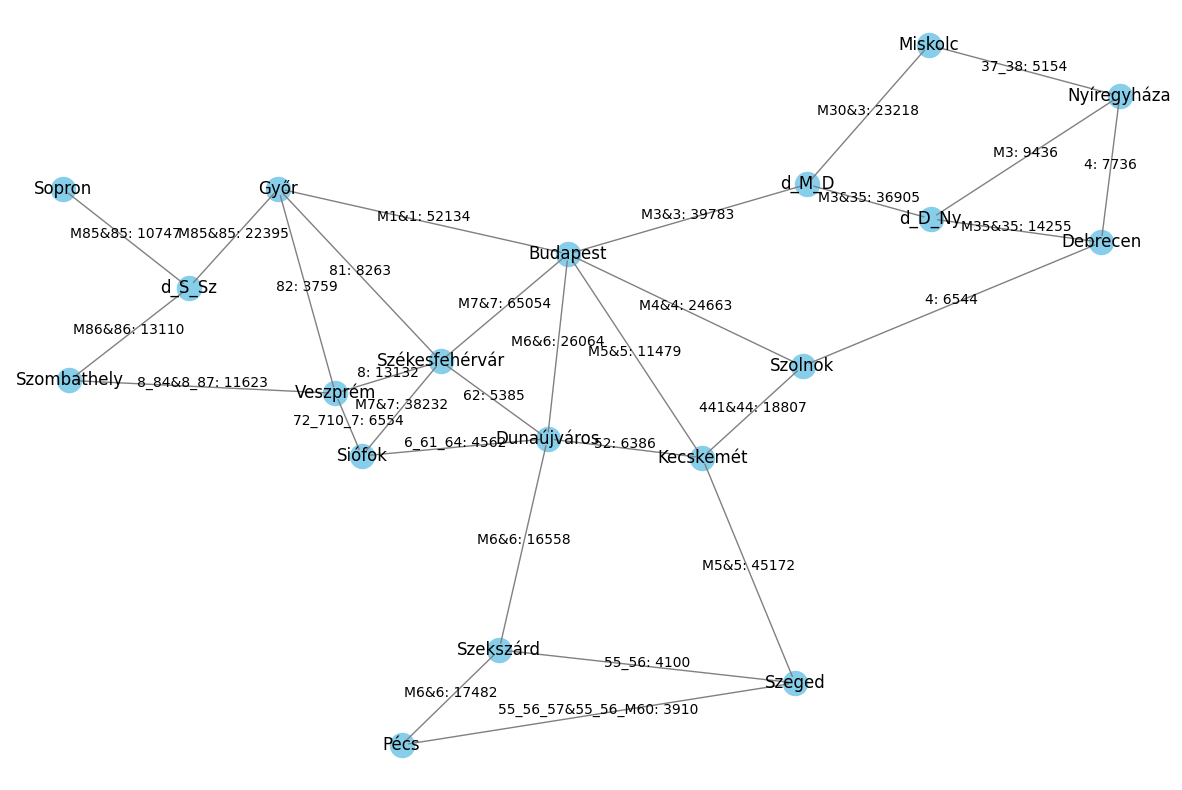

In [5]:
map_functions.plot_map_simple_graph(G_simple, pos, node_names)

E.g. shortest paths:

In [6]:
roads = list(G_simple.edges())
road_traffics = [G_simple.get_edge_data(road[0], road[1])['weight'] for road in roads]

locations = list(G_simple.nodes())
#locations.remove('div_point_Miskolc_Debrecen'); locations.remove('div_point_Debrecen_Nyíregyháza'); locations.remove('div_point_Sopron_Szombathely')
shortest_paths_dict = {}
for i in range(len(locations)):
    source = locations[i]
    for j in range(i+1,len(locations)):
        target = locations[j]
        if source != target:
            paths = nx.all_shortest_paths(G_simple, source=source, target=target)
            shortest_paths_dict[(source, target)] = list(paths)

In [7]:
extra_paths = computing_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']
v, P, odm, extra = computing_functions.v_P_odmbp_shortest_paths(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)
v_reduced, P_reduced, odm_reduced, extra_reduced = computing_functions.v_P_odmbp_reduced_matrix(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)

Sympy measured higher rank than numpy, extra steps are needed to take
Deleted rows list (index): [2]


There was an issue with Sympy giving different rank result than numpy (possibly the issue comes from digits accuracy). This seems to be fixed by the new approach.<br>
This is also stated here: [SymPy rank different from NumPy matrix rank](https://stackoverflow.com/questions/53792657/sympy-rank-different-from-numpy-matrix-rank)

In [10]:
np.linalg.matrix_rank(P_reduced), P_reduced.shape

(29, (29, 120))

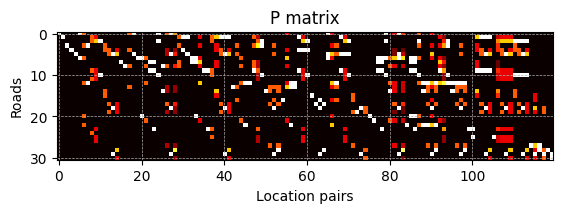

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.imshow(P, cmap='hot', interpolation='nearest')
#fig.colorbar(cax)
ax.set_title('P matrix')
ax.set_xlabel('Location pairs')
ax.set_ylabel('Roads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [13]:
from scipy.io import savemat

#Save the P matrix in a .mat file
savemat('computing/P/P_matrix_16_cities.mat', {'P': P})
np.savetxt("computing/P/P_matrix_16_cities.csv", P, delimiter=",", fmt='%.3f')
np.savetxt("computing/P/P_matrix_reduced_16_cities.csv", P_reduced, delimiter=",", fmt='%.3f')